# Thermal responses to pulse-like forcing changes

Comparison between two-layer and three-layer models

In [ ]:
%cd ..

In [2]:
import numpy as np
import pandas as pd
from mce.core.driver import DriverBase
from mce.util.plot_base import PlotBase

In [3]:
myplt = PlotBase(palette='ipcc_wg1')

## Calibrated thermal parameters

In [4]:
with pd.HDFStore('data/parms_calib_climate.h5', 'r') as store:
    df_parms_nl2 = (
        store['cmip_norm1__nl2'] # 3-layer model
        .sort_index(key=lambda x: x.str.lower())
    )
    df_parms_nl3 = (
        store['cmip_norm1__nl3'] # 3-layer model
        .sort_index(key=lambda x: x.str.lower())
    )

In [5]:
# Normalized CMIP data for comparison
with pd.HDFStore('data/cmip_normalized.h5', 'r') as store:
    df_norm = {
        'CMIP5':
        store['CMIP5/climate_norm1']
        .rename({'abrupt4xCO2': 'abrupt-4xCO2'}),
        'CMIP6':
        store['CMIP6/climate_norm1'],
    }

## Custom drivers

In [6]:
class Driver(DriverBase):
    seconds_per_year = 3.15569e7
    earth_area = 5.10e14 # m^2
    conversion_factor = {
        ('J spy-1 m-2', 'ZJ'): seconds_per_year * earth_area * 1e-21,
    }

In [7]:
class Driver4x(Driver):
    """Driver for computing thermal response to step forcing
    using a simple response function instead of generic time integration
    """
    def run(self, time, erf=None):
        climate = self.climate

        if erf is None:
            erf = self.forcing.x2erf(4)

        resp = climate.response_ideal(time, kind='step', variable='flux')
        resp_a = climate.response_ideal(time, kind='step', variable='heat')
        factor = self.conversion_factor[('J spy-1 m-2', 'ZJ')]

        return erf * pd.DataFrame({
            'rtnt': resp,
            'tas': (1 - resp) / climate.parms.lamb,
            'thc': resp_a * factor,
        }, index=time)

    def step2pulse(self, d_step, duration=1, interval=0):
        """Convert step response to pulse response by superposition

        Parameters
        ----------
        d_step
            Input step response
        duration, optional
            Pulse length in year, by default 1
        interval, optional
            Regular spacing of multiple pulses in year,
            by default 0, which means single pulse

        Returns
        -------
            Resulting DataFrame
        """
        d_pulse = d_step.sub(d_step.shift(duration))
        d_pulse.where(d_pulse.isna()==False, d_step, inplace=True)
        n = 1
        d1 = d_pulse.copy()
        if interval > 0:
            while 1:
                nst = n * interval
                if nst >= len(d_pulse):
                    break
                d1a = d_pulse.add(d1.shift(nst))
                d_pulse = d1a.where(d1a.isna()==False, d_pulse)
                n = n + 1

        return d_pulse

    def get_pulse_response(self, time, erf, duration=1, interval=0):
        """Response to pulse forcing

        Parameters
        ----------
        time
            Time points in year
        erf
            Forcing level in W m-2
        duration, optional
            Pulse length in year, by default 1
        interval, optional
            Regular spacing of multiple pulses in year,
            by default 0, which means single pulse

        Returns
        -------
            Resulting DataFrame
        """
        df = self.run(time, erf)
        df = df.transform(
            self.step2pulse, axis=0, duration=duration, interval=interval,
        )

        return df

    def get_pulse_peak(self, time, erf, duration, interval):
        """Peak responses to a series of regularly-spaced pulse forcing

        Parameters
        ----------
        time
            Time points in year
        erf
            Forcing level in W m-2
        duration
            Pulse length in year
        interval
            Spacing of multiple pulses in year

        Returns
        -------
            Resulting DataFrame
        """
        climate = self.climate
        akj = self.save['climate']['akj']
        xik = self.save['climate']['xik']
        tauj = climate.parms.tauj
        factor = self.conversion_factor[('J spy-1 m-2', 'ZJ')]

        npulse = (time - duration) / interval + 1.
        bl = npulse == np.floor(npulse + 1e-6)
        # time[bl]: Time points when local peaks occur
        # npulse[bl]: Number of experienced pulses at local peaks

        # Peak response to single pulse
        d1 = akj * (1. - np.exp(-duration/tauj))
        # Dissipation factor after N pulses, calculated as
        # 1 + r + r**2 + ... + r**(n-1)
        r = np.exp(-(interval/tauj))
        d2 = (1. - r ** npulse[bl][:, None, None]) / (1. - r)

        # Sum of components in terms of time constants
        df = (d1 * d2).sum(axis=2)

        ## Changes in the surface temperature and the total heat content
        df = pd.DataFrame({
            'tas': df[:, 0],
            'thc': (df * xik[None, :]).sum(axis=1) * factor,
        }, index=time[bl]).mul(erf / climate.parms.lamb)

        return df

In [8]:
class Driver1p(Driver):
    """Driver for 1pctCO2 using a climate-only response function
    instead of generic time integration
    """
    def run(self, time):
        climate = self.climate
        forcing = self.forcing
        akj = self.save['climate']['akj']
        xik = self.save['climate']['xik']

        f1p = self.forcing.xl2erf(time * np.log(1.01))
        resp = climate.response(time, f1p, akj=akj)
        factor = self.conversion_factor[('J spy-1 m-2', 'ZJ')]

        return pd.DataFrame({
            'rtnt': f1p - climate.parms.lamb * resp[:, 0],
            'tas': resp[:, 0],
            'thc': (resp * xik).sum(axis=1) * factor,
        }, index=time)

## Responses to idealized CO2 forcing changes

In [9]:
# Use IPSL-CM6A-LR as an example
mip, dataset = 'CMIP6', 'IPSL-CM6A-LR'
df = df_norm[mip].loc[dataset]

gcm = {
    ('4x', 'rtnt'): df.loc[('abrupt-4xCO2', 'rtnt')].dropna().values,
    ('4x', 'tas'): df.loc[('abrupt-4xCO2', 'tas')].dropna().values,
    ('1p', 'rtnt'): df.loc[('1pctCO2', 'rtnt')].dropna().values,
    ('1p', 'tas'): df.loc[('1pctCO2', 'tas')].dropna().values,
}
sca = Driver.conversion_factor[('J spy-1 m-2', 'ZJ')]
gcm[('4x', 'thc')] = gcm[('4x', 'rtnt')].cumsum() * sca
gcm[('1p', 'thc')] = gcm[('1p', 'rtnt')].cumsum() * sca

time = np.arange(150) + 0.5

In [10]:
p = df_parms_nl2.loc[(mip, dataset)]
kw_nl2 = {
    'kw_rfall': {
        'alpha': p['co2_alpha'],
        'beta': p['co2_beta'],
    },
    'kw_irm': {
        'asj': p[['a0', 'a1']].values,
        'tauj': p[['tau0', 'tau1']].values,
        'lamb': p['lambda'],
    }
}

In [11]:
p = df_parms_nl3.loc[(mip, dataset)]
kw_nl3 = {
    'kw_rfall': {
        'alpha': p['co2_alpha'],
        'beta': p['co2_beta'],
    },
    'kw_irm': {
        'asj': p[['a0', 'a1', 'a2']].values,
        'tauj': p[['tau0', 'tau1', 'tau2']].values,
        'lamb': p['lambda'],
    }
}

In [12]:
config = {'climate': {'nl': 2}} # two-layer
drv = Driver4x(**{**config, **kw_nl2})
df_irm2_4x = drv.run(np.arange(151).astype('d'))
drv = Driver1p(**{**config, **kw_nl2})
df_irm2_1p = drv.run(np.arange(141).astype('d'))

In [13]:
config = {'climate': {'nl': 3}} # three-layer (default)
drv = Driver4x(**{**config, **kw_nl3})
df_irm3_4x = drv.run(np.arange(151).astype('d'))
drv = Driver1p(**{**config, **kw_nl3})
df_irm3_1p = drv.run(np.arange(141).astype('d'))

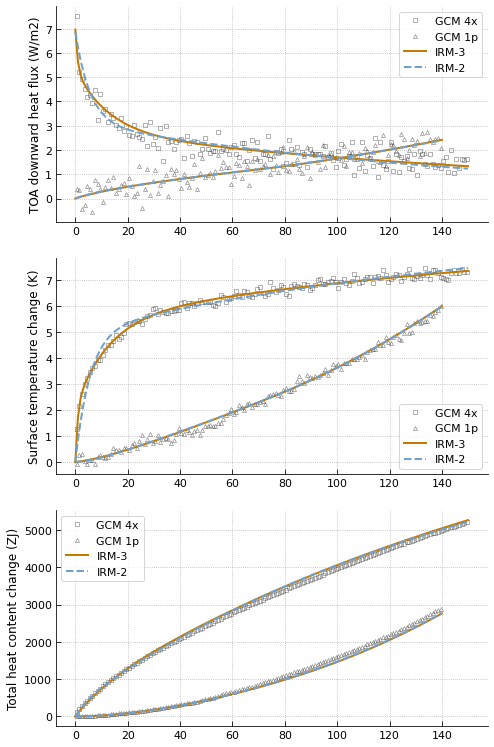

In [14]:
myplt.init_regular(
    3, kw_space={'height': 3., 'aspect': 2., 'hspace': 0.5},
)

kw_gcm = {
    'ls': 'None', 'mec': 'C0', 'mfc': 'none',
    'mew': 0.6, 'ms': 4, 'alpha': 0.5,
}
color_nl2 = 'C1'
color_nl3 = 'C2'
kw_irm2 = {'lw': 2., 'ls': '--', 'color': color_nl2}
kw_irm3 = {'lw': 2., 'color': color_nl3}

map_label = {
    'rtnt': 'TOA downward heat flux (W/m2)',
    'tas': 'Surface temperature change (K)',
    'thc': 'Total heat content change (ZJ)',
}

for n, vn in enumerate(['rtnt', 'tas', 'thc']):
    ax = myplt(n)

    ax.plot(time, gcm[('4x', vn)], label='GCM 4x', marker='s', **kw_gcm)
    ax.plot(time[:140], gcm[('1p', vn)], label='GCM 1p', marker='^', **kw_gcm)

    d1 = df_irm3_4x[vn]
    ax.plot(d1.index, d1, label='IRM-3', **kw_irm3)
    d1 = df_irm2_4x[vn]
    ax.plot(d1.index, d1, label='IRM-2', **kw_irm2)

    ax.legend()

    d1 = df_irm3_1p[vn]
    ax.plot(d1.index, d1, label='IRM-3', **kw_irm3)
    d1 = df_irm2_1p[vn]
    ax.plot(d1.index, d1, label='IRM-2', **kw_irm2)

    ax.set_ylabel(map_label[vn])
    ax.grid()

## Responses to a series of multiple pulses

Based on Gupta and Marshall (2018, https://doi.org/10.1175/JCLI-D-17-0703.1) regarding multiple volcanic eruptions

In [15]:
time = np.arange(60).astype('d')
erf1 = -1.
duration = 1
interval = 10

config = {'climate': {'nl': 2}} # two-layer
drv = Driver4x(**{**config, **kw_nl2})

df_2l = drv.get_pulse_response(time, erf1, duration, interval)
df_2l_peak = drv.get_pulse_peak(time, erf1, duration, interval)

config = {'climate': {'nl': 3}} # three-layer (default)
drv = Driver4x(**{**config, **kw_nl3})
df_3l = drv.get_pulse_response(time, erf1, duration, interval)
df_3l_peak = drv.get_pulse_peak(time, erf1, duration, interval)

In [16]:
(
    np.allclose(df_2l_peak, df_2l.loc[df_2l_peak.index, df_2l_peak.columns]),
    np.allclose(df_3l_peak, df_3l.loc[df_3l_peak.index, df_3l_peak.columns]),
)

(True, True)

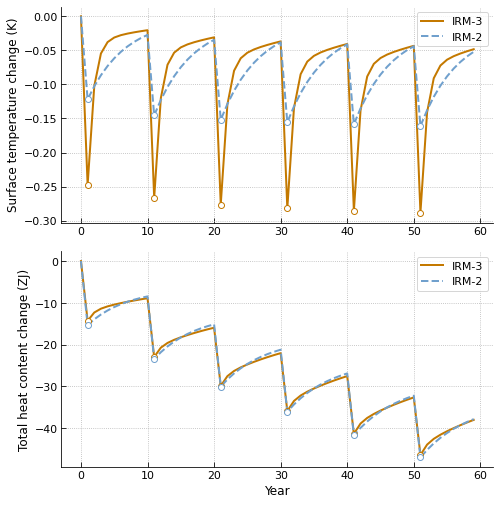

In [17]:
myplt.init_regular(2, kw_space={'aspect': 2., 'hspace': 0.4})

kw_marker = {'ls': 'None', 'marker': 'o', 'mfc': 'w'}

for n, vn in enumerate(['tas', 'thc']):
    ax = myplt(n)

    d1 = df_3l[vn]
    ax.plot(d1.index, d1, label='IRM-3', **kw_irm3)
    d1 = df_2l[vn]
    ax.plot(d1.index, d1, label='IRM-2', **kw_irm2)

    ax.legend()

    d1 = df_3l_peak[vn]
    ax.plot(d1.index, d1, mec=color_nl3, **kw_marker)
    d1 = df_2l_peak[vn]
    ax.plot(d1.index, d1, mec=color_nl2, **kw_marker)

    if n == 1:
        ax.set_xlabel('Year')

    ax.set_ylabel(map_label[vn])
    ax.grid()